In [109]:
import sys
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xray
import random
import itertools
import importlib as imp

sys.path.append('/nuwa_cluster/home/jackyu/climatools/')
import climatools.dates as climadates
import climatools.viz as climaviz
import climatools.misc as climamisc
import climatools.muths as climaths
import climatools.units as climaunits

#from IPython.lib.deepreload import reload as dreload
imp.reload(climadates)
imp.reload(climaviz)
imp.reload(climamisc)
imp.reload(climaths)
imp.reload(climaunits)

matplotlib.rcParams.update({'font.size': 13, 
                            'xtick.direction': 'out',
                            'ytick.direction': 'out'})

# MPACE

# Cases and netCDF file paths

3 cases considered here are:

* LWclirad  --- longwave radiation calculated using CLIRAD
* LWclirad no scat.  ---  longwave radiation calculated using CLIRAD, but with cloud scattering removed
* LWrrtmg --- longwave radiation calculated using RRTMG (this has no cloud scattering)

In [110]:
# Each case here refers to a model, or a model configuration, and is assigned the path to its output data.
def get_cases():
    '''
    Returns a dictionary where the keys are cases, such
    as a name for a SCAM run, and the values are the paths
    to the output data from the run
    '''
    return {'LWclirad': '../examples/MPACE_LWclirad_SWrrtmg/MPACE_cam5_3hrly/camrun.cam.h0.2004-10-05-07171.nc',
            'LWclirad no scat.': '../examples/MPACE_LWclirad_SWrrtmg/MPACE_cam5_3hrly_NoCloudScattering/camrun.cam.h0.2004-10-05-07171.nc',
            'LWrrtmg': '../examples/MPACE_LWrrtmg_SWrrtmg/MPACE_cam5_3hrly/camrun.cam.h0.2004-10-05-07171.nc'}

# Coordinate conversions
*lev* is converted from hybrid levels to mbar.    
*time* is converted from days since start to datetime.datetime objects

In [111]:
def convert_pressure_time_units(cases):
    '''
    Convert pressure and time units to mbar and datetime objects.
    This assumes all datasets have the same pressure and time
    coordinates.  This conversion is done early using fields such as
    hyam, which will not be needed later.
    '''
    with xray.open_dataset(cases[random.choice(list(cases.keys()))], 
                           decode_times = False) as ds:
        pressure = climaunits.lev_hybrid2mbar(ds)
        datetimes = climadates.time2datetimes(ds)     
    return pressure, datetimes

In [112]:
cases = get_cases()
pressure, datetimes = convert_pressure_time_units(cases)

In [113]:
################## Variables of dimensions (time, lev, lon, lat) ########################
################################################################################

In [114]:
### for pre-processing



def get_d3interests():
    '''List all interested fields here.  
    These have to be of dimensions (time, lev, lon, lat)'''
    d3interests = ['CLOUD', 'QRL', 'QRS', 'Q',
                   'CLDICE', 'CLDLIQ', 
                   'AQSNOW', 'AREI', 'AREL',
                  'AWNC', 'AWNI', 
                   'DCQ', 'DTCOND', 
                   'ICIMR', 'ICWMR', 
                   'NUMLIQ', 'NUMICE', 'T']
    return sorted(d3interests)


def gather_interests_from_cases(cases, interests):
    '''
    Creates a dictionary with keys being the cases.
    For each case is an Xray Dataset containing the interested fields
    '''
    datasets = {} 

    for case, filepath in cases.items():
        with xray.open_dataset(filepath, decode_times = False) as ds:
            datasets[case] = ds[interests].copy(deep = True)
            datasets[case].attrs['case_name'] = case
    return datasets


def convert_units(datasets, pressure, datetimes):
    '''
    Convert units for certain fields for all cases in DATASETS.
    INPUT:
    pressure --- pressure in mbar
    datetimes --- time in pandas DatetimeIndex objects
    '''
    for name, ds in datasets.items():
        ds.coords['lev'] = ('lev', pressure, {'units': 'mbar'})
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime'})
    
        if 'QRL' in ds:
            ds['QRL'] *= 86400
            ds['QRL'].attrs['units'] = 'K/day'
        
        for k in ['Q', ]:
            if k in ds:
                ds[k] *= 1e3
                ds[k].attrs['units'] = 'g/kg'
        
        for k in ['CLDICE', 'CLDLIQ', 'AQSNOW']:
            if k in ds:
                ds[k] *= 1e6
                ds[k].attrs['units'] = 'mg/kg'
    return datasets


def take_difference_between_cases(datasets):
    '''
    Take the difference between all cases for every field
    and return in a similar dictionary
    '''
    diff_strs = [('LWclirad', 'LWrrtmg'), 
                 ('LWclirad no scat.', 'LWrrtmg'), 
                 ('LWclirad', 'LWclirad no scat.')]

    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}


def passon_attrs_casename(datasets, diff_datasets):
    '''
    Create an attribute for each case.
    Copy over attributes to the differences.
    This is not nice, might be good to get rid of 
    the dependency on this.
    '''
    interests = get_d3interests()
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(datasets['LWrrtmg'][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets


def prep_data(cases, pressure, datetimes):
    '''
    Preprocess data for plotting. 
    pressure and datetimes need to be provided for unit conversion.
    INPUT:
    pressure --- pressure in mbar
    datetimes --- time in pandas DatetimeIndex objects    
    '''
    interests = get_d3interests()
    datasets = gather_interests_from_cases(cases, interests)
    datasets = convert_units(datasets, pressure, datetimes)
    diff_datasets = take_difference_between_cases(datasets)
    datasets, diff_datasets = passon_attrs_casename(datasets, diff_datasets)
    return datasets, diff_datasets


def average_over_time(da):
    '''
    Average over time dimension of DA, while
    retaining its units and long_name attributes
    '''
    avgda = da.mean(dim = 'time')
    avgda.attrs['units'] = da.attrs['units']
    avgda.attrs['long_name'] = da.attrs['long_name']
    return avgda


In [115]:
### for plotting   

def get_line_props():
    return {'LWrrtmg': {'colour': 'g', 'linestyle': '--'},
           'LWclirad': {'colour': 'b', 'linestyle': '-'},
           'LWclirad no scat.': {'colour': 'b', 'linestyle': '--'}}    

def plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, 
                                               interest = 'CLOUD',
                                               xscale = 'linear', 
                                               bot_xlim = None, bot_xlabels_rotate = 0.,
                                               top_xlim = None, top_xlabels_rotate = 0.,
                                               yscale = 'linear', ylim = None,):
    line_props = get_line_props()
    
    vspairs = [[p.strip() for p in diff_case.split('-')]
               for diff_case in sorted(diff_d3sets.keys())]
    
    fig, axes = plt.subplots(figsize = (9, 9), dpi = 300,
                          nrows = 1, ncols = len(vspairs),
                            sharey = True)

    labels, handles = [], []
    
    axes[0].invert_yaxis()
    
    for ax, vspair in zip(axes, vspairs):
        x, y = vspair
        
        for model in vspair:
            da = average_over_time(d3sets[model][interest])
            
            # plot each member in the comparison pair
            ax = climaviz.plot_vertical_profile(ax, da, 
                                       label = '{}'.format(model), 
                                       colour = line_props[model]['colour'],
                                       linestyle = line_props[model]['linestyle'],
                                       xscale = xscale, xlabels_rotate = bot_xlabels_rotate,
                                       yscale = yscale)
       
        ax = climaviz.axes_beyond_ticks(ax, which = 'x')
        
        # plot difference on twiny
        ax2 = ax.twiny()      
        
        da = average_over_time(diff_d3sets[' - '.join(vspair)][interest])
        
        ax2 = climaviz.plot_vertical_profile(ax2, da, 
                                    label = 'difference',                             
                                    colour = (0.929, 0.329, 0.972), linestyle = '-',
                                    xscale = xscale, xlabels_rotate = top_xlabels_rotate,
                                    yscale = yscale)
        
        ax2 = climaviz.axes_beyond_ticks(ax2, which = 'x')  
        
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax.get_legend_handles_labels()
        handles.extend(handles1 + handles2)
        labels.extend(labels1 + labels2)
        
    ## Make 1 legend for whole figure
    uhandles, ulabels = climamisc.any_unique_labels(handles, labels)
    uhandles, ulabels = zip(*sorted(zip(uhandles, ulabels), key = lambda x: x[1]))
    fig.legend(uhandles, ulabels, 
               loc = 'center', ncol = 3,
               bbox_to_anchor = (.35, .85), prop = {'size': 12})
    
    fig.suptitle(da.attrs['long_name'])
    
    plt.figtext(x = 0.02, y = .5, s = 'lev [mbar]', rotation = 90.)
    plt.figtext(x = .45, y = 0.08, s = '{} [{}]'.format(interest, da.units))
    plt.figtext(x = .9, y = 0.08, s = '1e{}'.format(- ax.xaxis_pow))
    plt.figtext(x = .7, y = .91, s = 'difference')
    plt.figtext(x = .9, y = .91, s = '1e{}'.format(- ax2.xaxis_pow))
    plt.subplots_adjust(wspace = 0., top = .84, bottom = .15)

In [116]:
d3sets, diff_d3sets = prep_data(cases, pressure, datetimes)

In [117]:
############### Variables of dimensions (lon, lat, time) ##########################
###################################################################################

In [118]:
def get_d2interests():
    interests = ['FLNT', 'FLNS', 'CLDLOW', 'CLDMED', 'CLDHGH', 'CLDTOT']
    return interests

In [119]:
def prep_data():

    interests = get_d2interests()

    datasets = {}
    
    for casename, casepath in cases.items():
        with xray.open_dataset(casepath, decode_times = False) as ds:
            datasets[casename] = ds[interests].copy(deep = True)
            datasets[casename].attrs['case_name'] = casename
        
    for casename, ds in datasets.items():
        ds.coords['time'] = ('time', datetimes, {'units': 'datetime',
                                                'long_name': 'time'})
    return datasets

d2sets = prep_data()

In [120]:
#### Compute difference between all cases for all interested variables
def prep_differences(datasets):
    diff_strs = [('LWclirad', 'LWrrtmg'), 
                 ('LWclirad no scat.', 'LWrrtmg'), 
                 ('LWclirad', 'LWclirad no scat.')]

    return {x + ' - ' + y: datasets[x] - datasets[y] 
            for x, y in diff_strs}    

diff_d2sets = prep_differences(d2sets)

In [121]:
#### Change/correct some of the attributes
## Some of this is needed for labelling plots easily

def prep_attributes(datasets, diff_datasets):
    
    interests = get_d2interests()
    
    for ds_name, ds in diff_datasets.items():
        ds.attrs['case_name'] = ds_name
        for interest in interests:
            ds[interest].attrs = dict(datasets['LWrrtmg'][interest].attrs)
            ds[interest].attrs['case_name'] = ds_name
        
    for ds_name, ds in datasets.items():
        for interest in interests:
            ds[interest].attrs['case_name'] = ds_name
            
    return datasets, diff_datasets

d2sets, diff_d2sets = prep_attributes(d2sets, diff_d2sets)

In [122]:
def plotVS_interest_for_all_cases(dsets, diff_dsets, interest = 'FLNT',
                                 left_ylim = (-1, 1),
                                 right_ylim = (-1, 1)):

    line_props = get_line_props()
    
    vspairs = [[p.strip() for p in diff_case.split('-')]
               for diff_case in sorted(diff_dsets.keys())]
    
    fig, axes = plt.subplots(figsize = (11, 11), dpi = 300,
                          nrows = len(vspairs), ncols = 1)
    
    handles, labels = [], []
    
    for ax, vspair in zip(axes, vspairs):
        x, y = vspair
        
        for model in vspair:
            ax = climaviz.plot_DataArray(ax, dsets[model][interest], 
                                         label = '{}'.format(model), 
                                         colour = line_props[model]['colour'],
                                         linestyle = line_props[model]['linestyle'],
                                         ylabel = interest, ylim = left_ylim)
        
        da = diff_dsets[' - '.join(vspair)][interest]        
        
        diff_colour = (0.929, 0.329, 0.972)
        ax2 = ax.twinx()
        ax2 = climaviz.plot_DataArray(ax2, da, label = 'difference',
                                      title = '',                              
                                      colour = diff_colour, linestyle = '-',
                                      ylim = right_ylim)
        ax2.set_ylabel('')
        [label.set_color(diff_colour) 
         for label in ax2.yaxis.get_ticklabels()]
        
        ### background shading for daytime and nighttime
        ax2 = climaviz.daytime_nighttime_shading(ax2, da.coords['time'].to_pandas().index,
                                       hour_daystart = 6, hour_nightstart = 18)
        
        ## collect handles and labels for legend later
        handles1, labels1 = ax.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()    
        handles.extend(handles1 + handles2)
        labels.extend(labels1 + labels2)
   
    ## Make 1 legend for whole figure
    uhandles, ulabels = climamisc.any_unique_labels(handles, labels)
    uhandles, ulabels = zip(*sorted(zip(uhandles, ulabels), 
                                    key = lambda x: x[1]))
    fig.legend(uhandles, ulabels, 
               loc = 'upper center', ncol = 4,
               bbox_to_anchor = (.45, .9), prop = {'size': 12})
    
    fig.suptitle(da.attrs['long_name'])


# Variables of dimensions (time, lev, lon, lat)

### Average snow mixing ratio (AQSNOW)

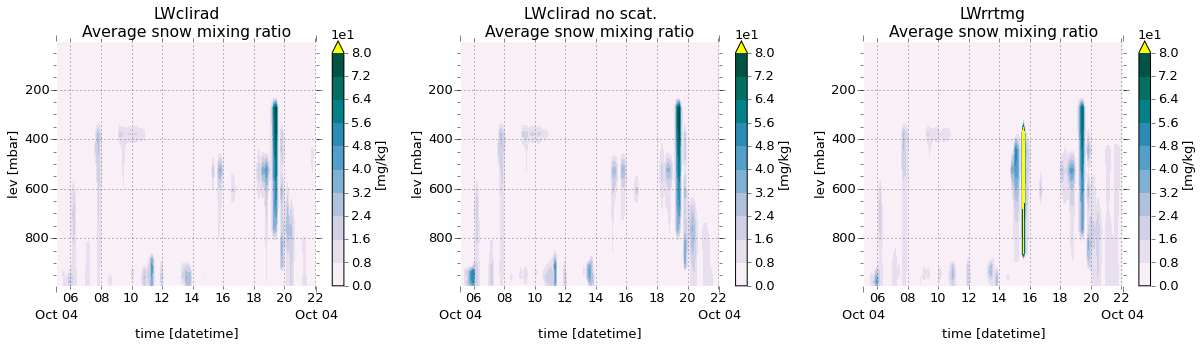

In [123]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'AQSNOW', cmap = plt.get_cmap('PuBuGn'))

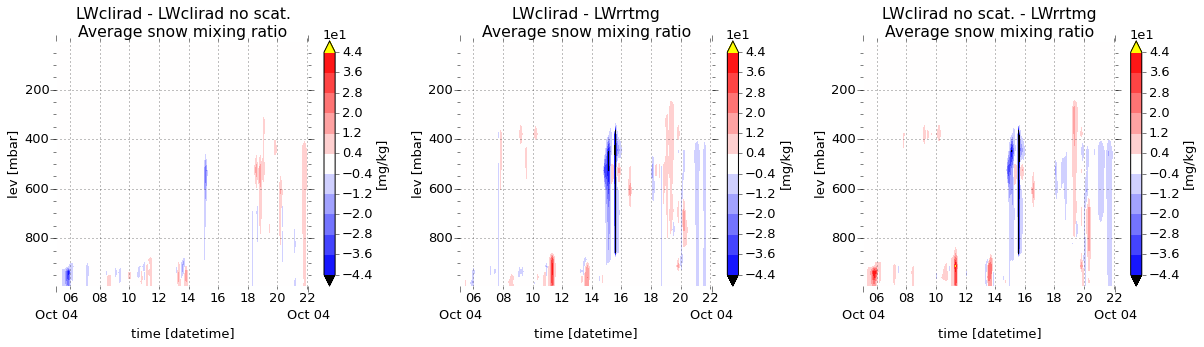

In [124]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'AQSNOW', cmap = plt.get_cmap('bwr'))

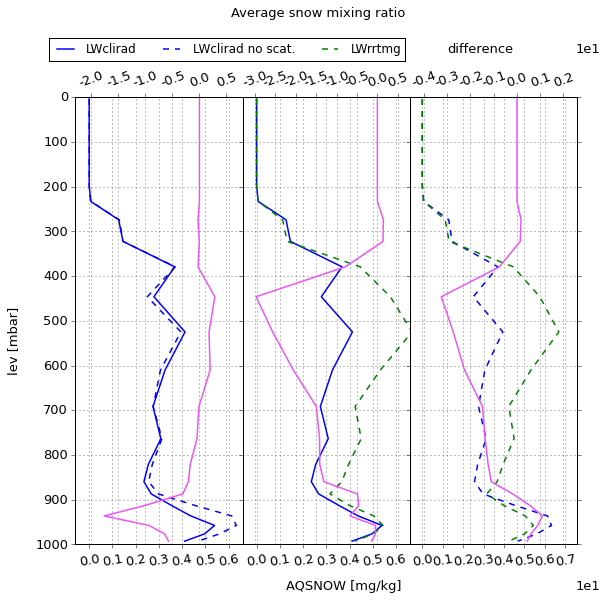

In [125]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'AQSNOW', xscale = 'linear',
                                           bot_xlabels_rotate = 10., top_xlabels_rotate = 20.)

### Average ice effective radius (AREI)

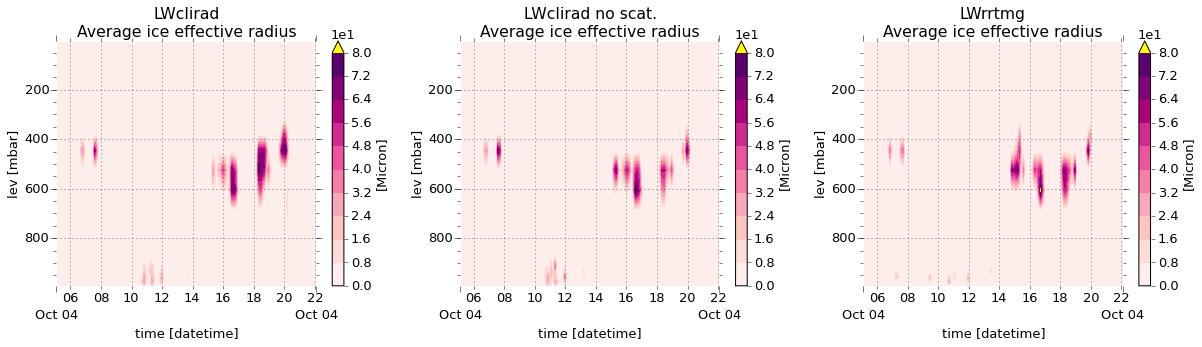

In [126]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'AREI', cmap = plt.get_cmap('RdPu'),)

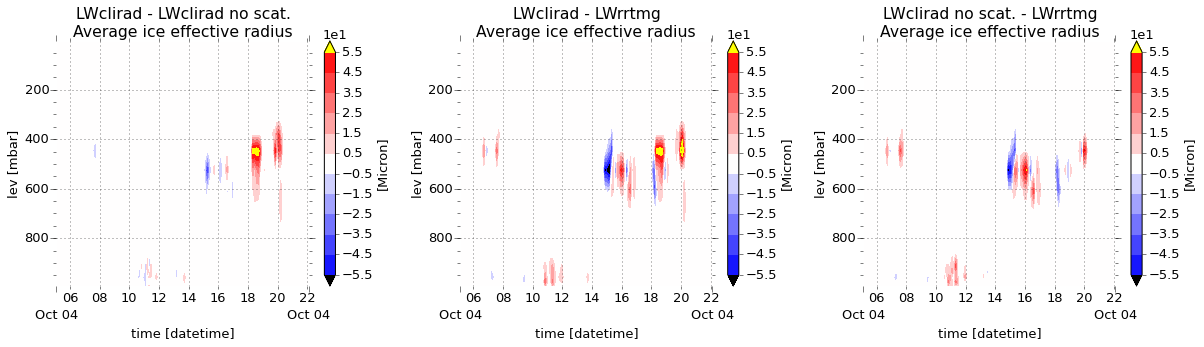

In [127]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'AREI', cmap = plt.get_cmap('bwr'))

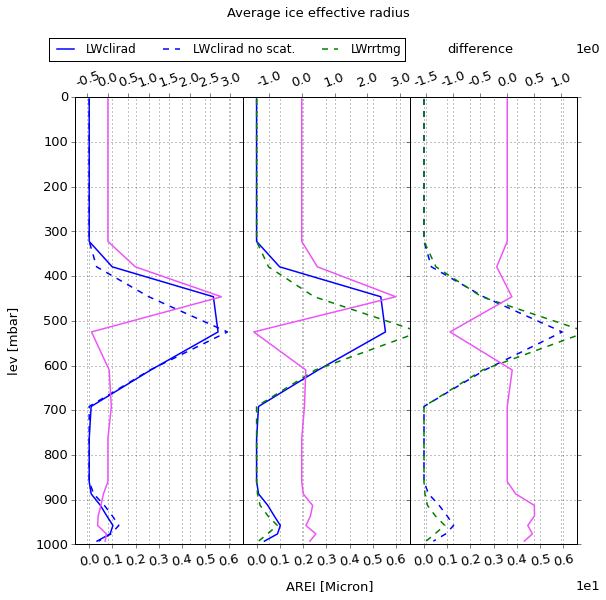

In [128]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'AREI', xscale = 'linear',
                                           bot_xlabels_rotate = 10.,
                                           top_xlabels_rotate = 20.)

### Average droplet effective radius (AREL)

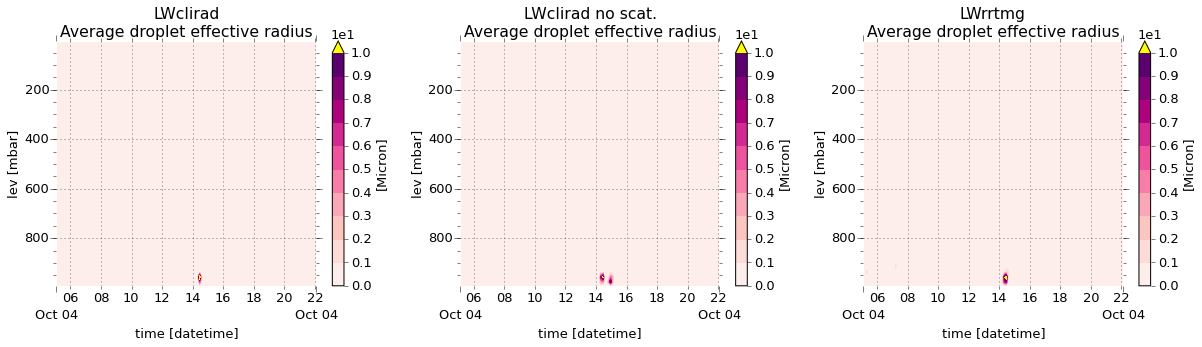

In [129]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'AREL', cmap = plt.get_cmap('RdPu'))

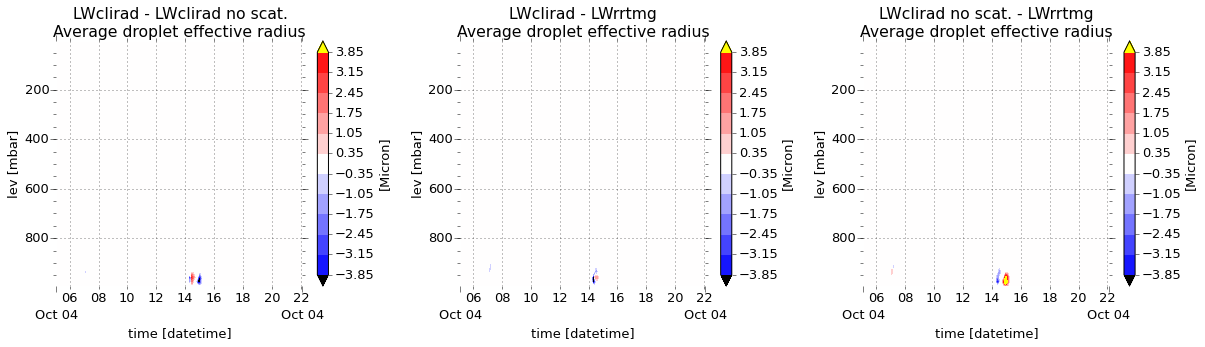

In [130]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'AREL', cmap = plt.get_cmap('bwr'))

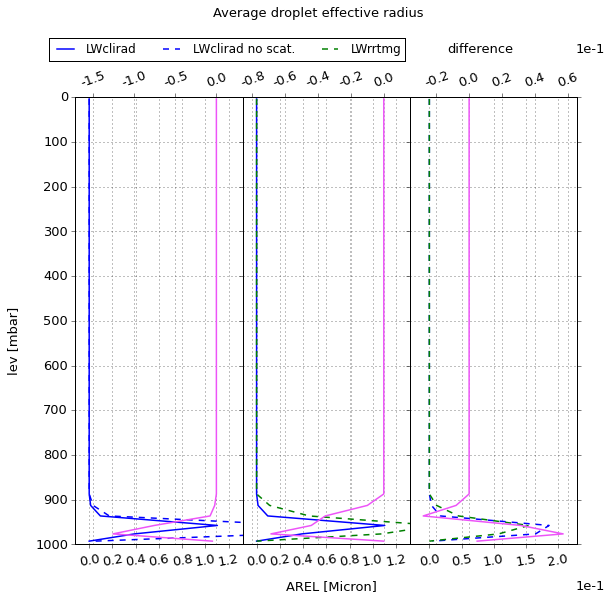

In [131]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'AREL', xscale = 'linear',
                                           bot_xlabels_rotate = 10., top_xlabels_rotate = 20.)

### Average cloud water number conc (AWNC)

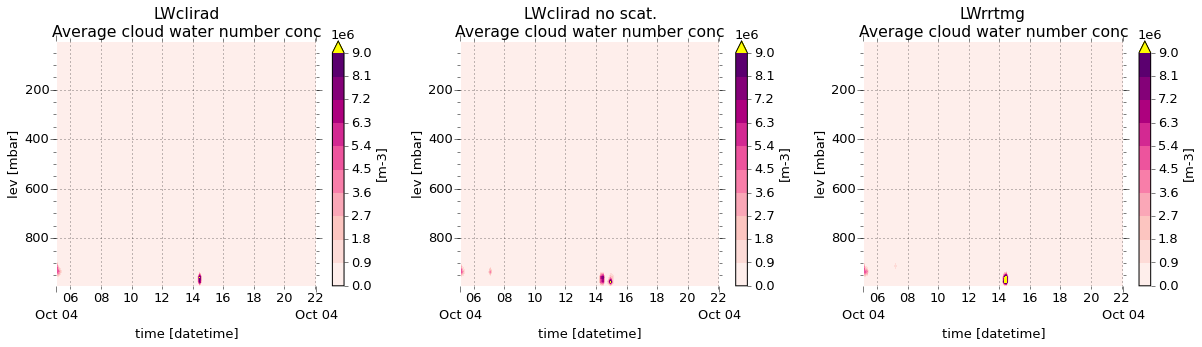

In [132]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'AWNC', cmap = plt.get_cmap('RdPu'))

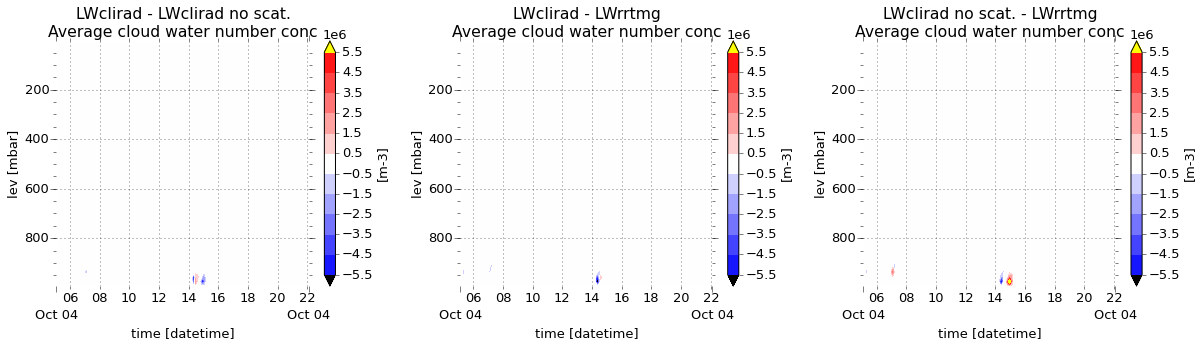

In [133]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'AWNC', cmap = plt.get_cmap('bwr'))

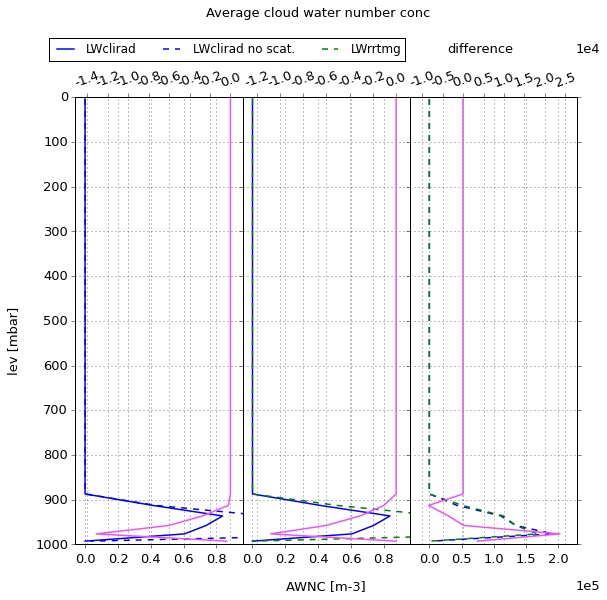

In [134]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'AWNC', 
                                           xscale = 'linear', top_xlabels_rotate = 20.)

### Average cloud ice number conc (AWNI)

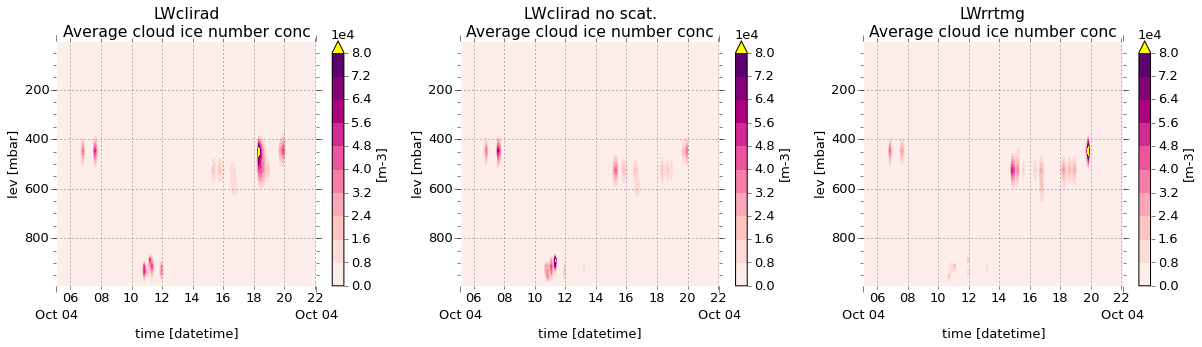

In [135]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'AWNI', cmap = plt.get_cmap('RdPu'))

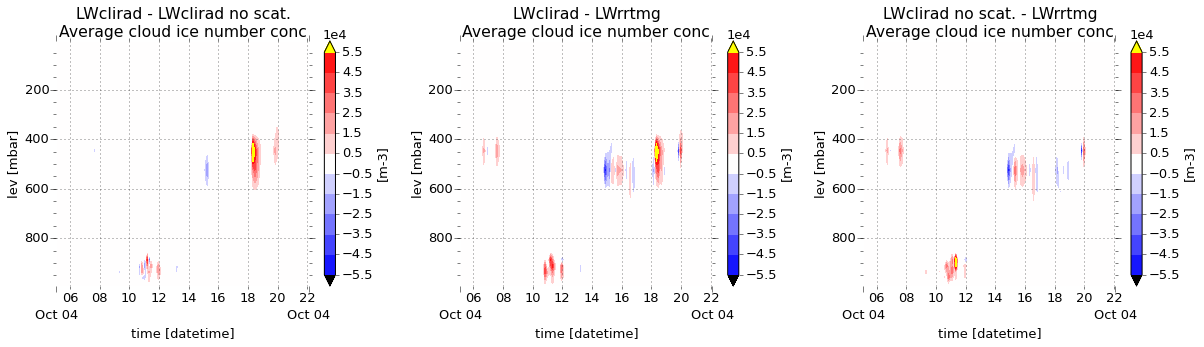

In [136]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'AWNI', cmap = plt.get_cmap('bwr'))

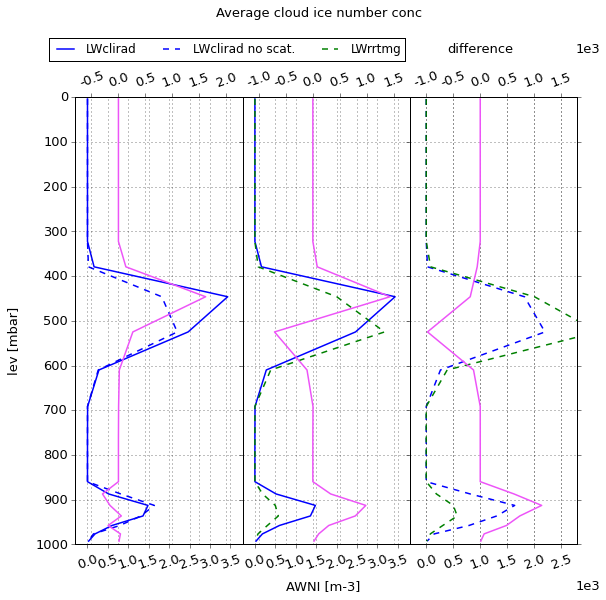

In [137]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'AWNI', 
                                           xscale = 'linear', bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Grid box averaged cloud ice amount (CLDICE) 

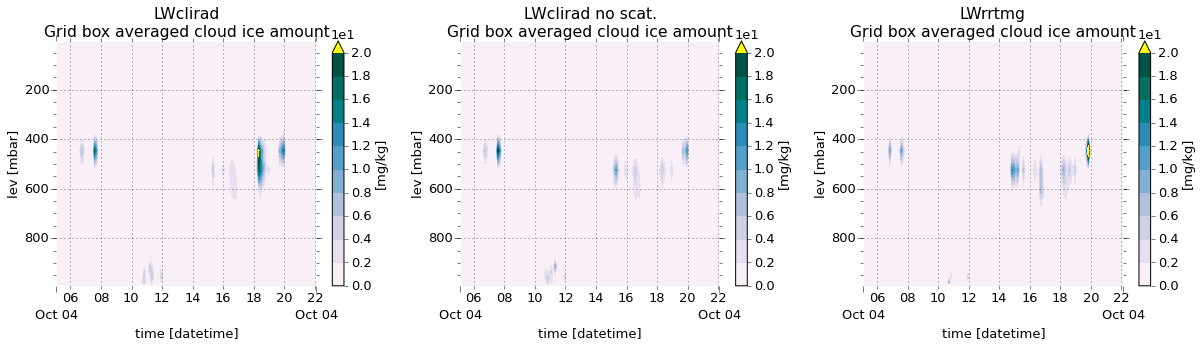

In [138]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'CLDICE', cmap = plt.get_cmap('PuBuGn'))

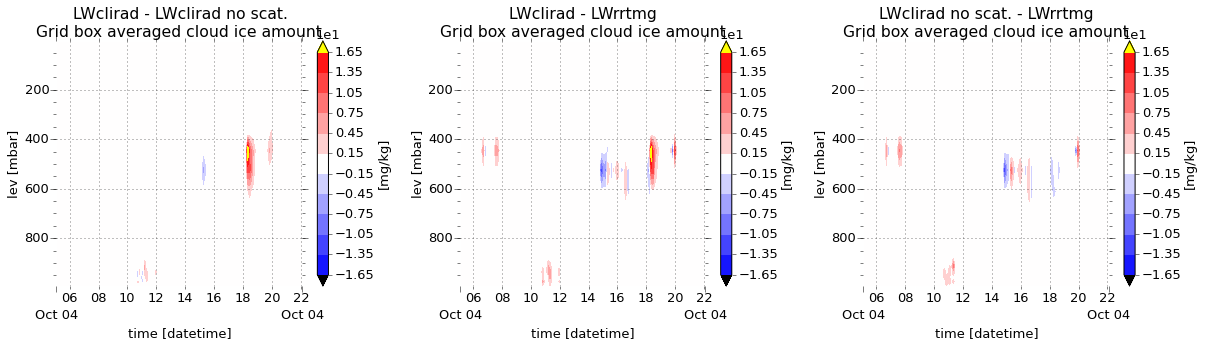

In [139]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'CLDICE', cmap = plt.get_cmap('bwr'))

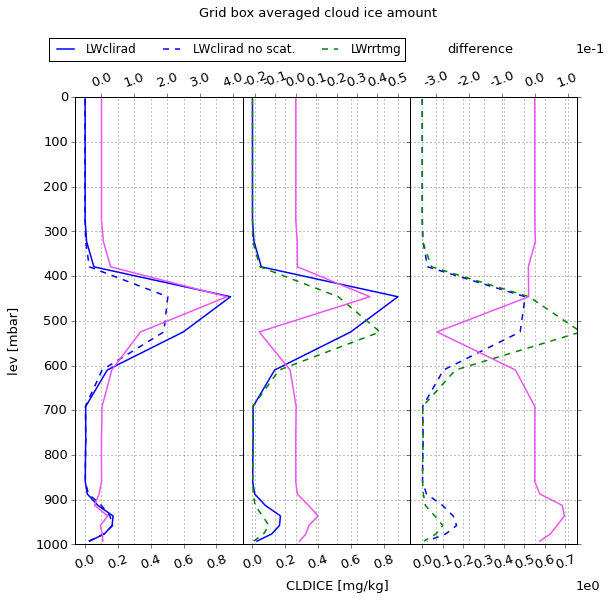

In [140]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'CLDICE', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Grid box averaged cloud liquid amount (CLDLIQ)

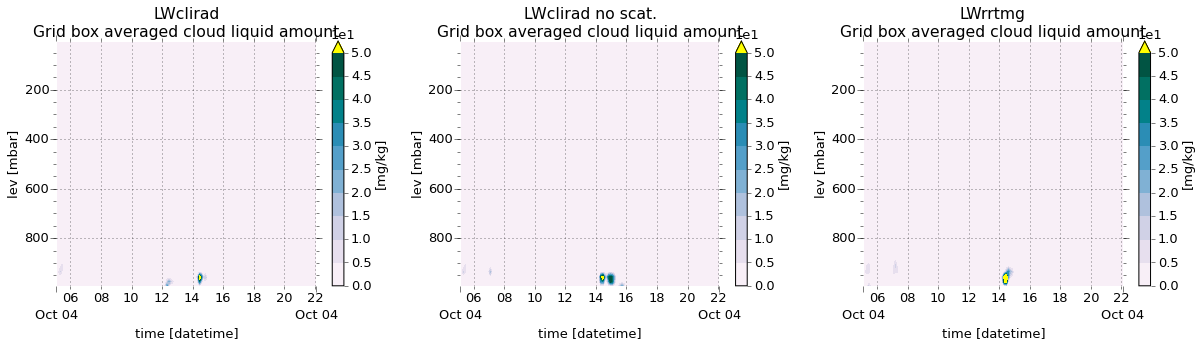

In [141]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'CLDLIQ', cmap = matplotlib.cm.PuBuGn)

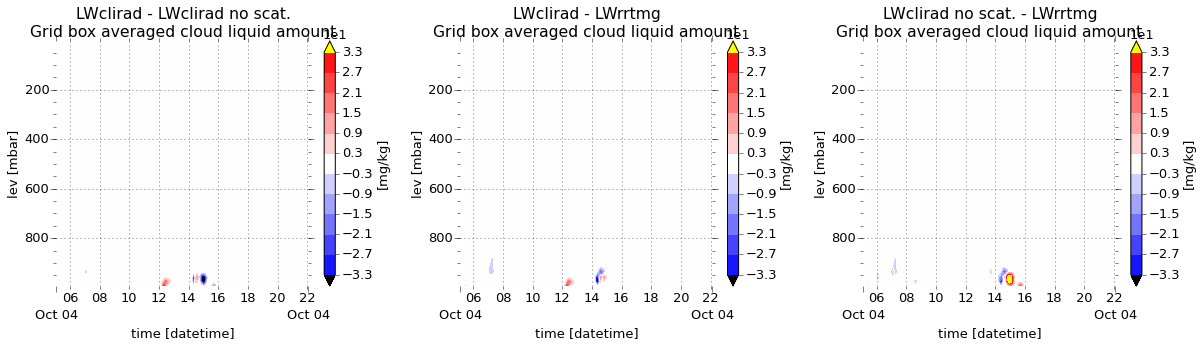

In [142]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'CLDLIQ', cmap = matplotlib.cm.bwr)

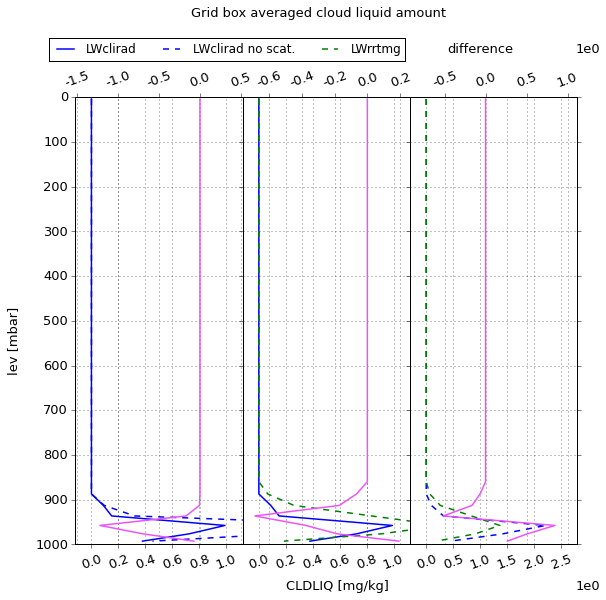

In [143]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'CLDLIQ', xscale = 'linear',
                                           bot_xlabels_rotate = 20.,top_xlabels_rotate = 20.)

### Cloud fraction (CLOUD)

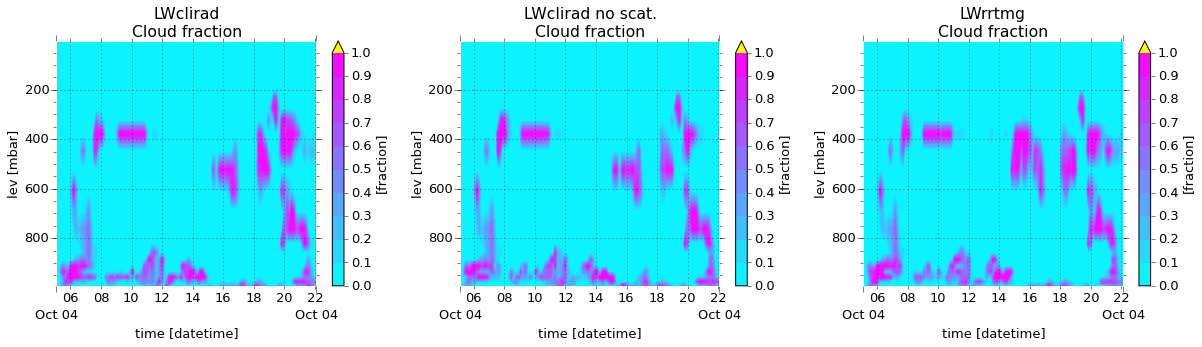

In [144]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'CLOUD', cmap = matplotlib.cm.cool)

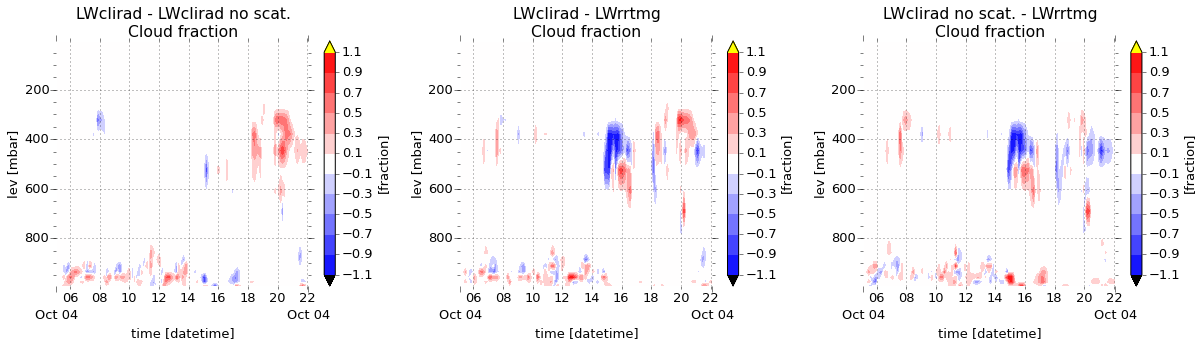

In [145]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'CLOUD', cmap = matplotlib.cm.bwr)

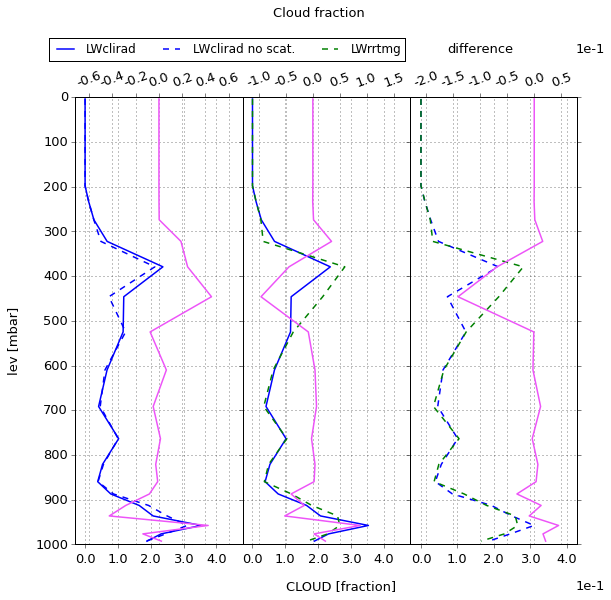

In [146]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'CLOUD', xscale = 'linear',
                                           top_xlabels_rotate = 20.)

### Q tendency due to moist processes (DCQ)

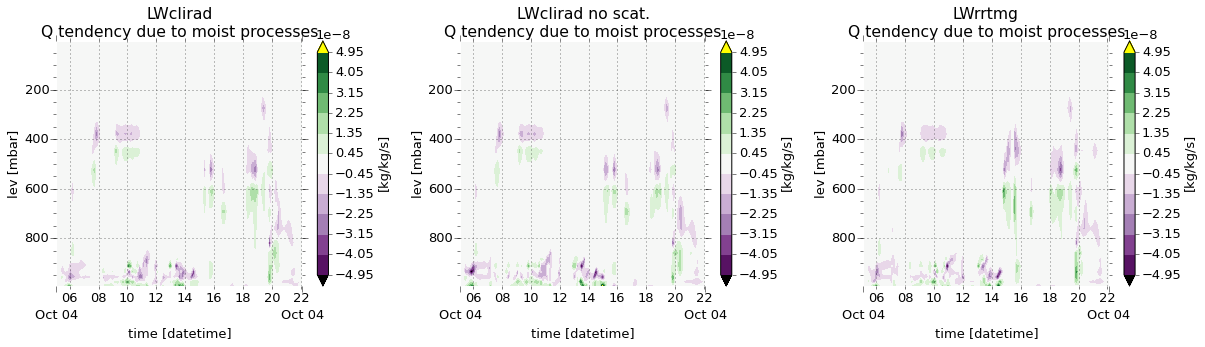

In [147]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'DCQ', cmap = matplotlib.cm.PRGn)

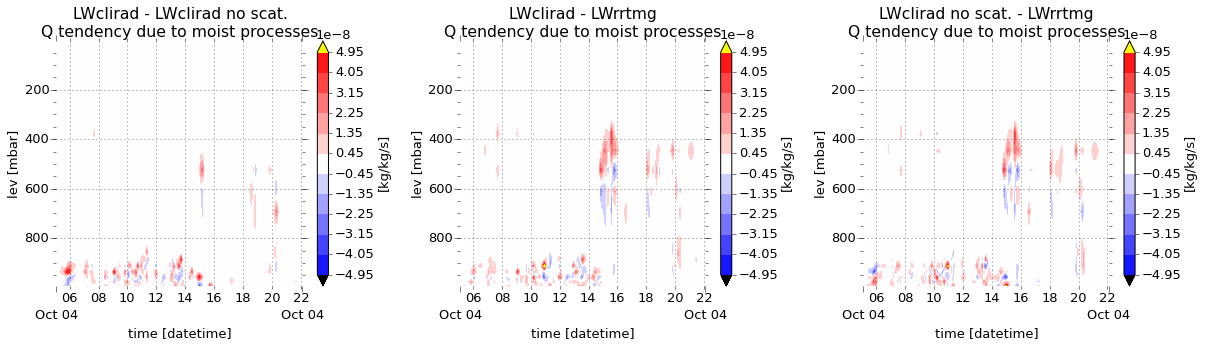

In [148]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'DCQ', cmap = matplotlib.cm.bwr)

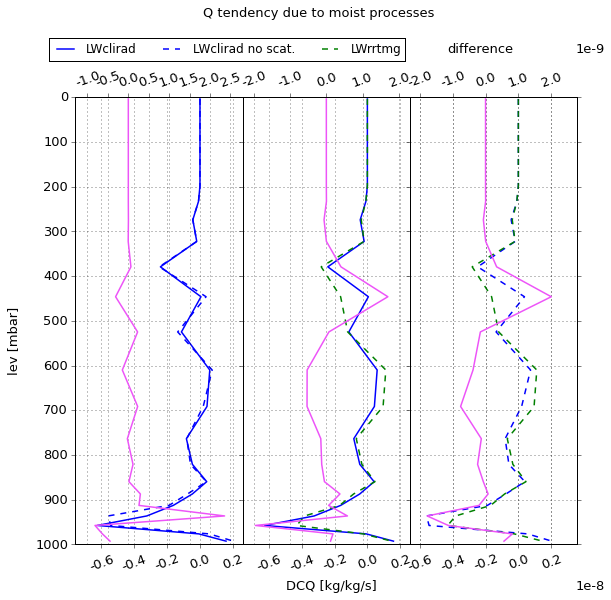

In [149]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'DCQ', xscale = 'linear',
                                          bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

###  T tendency - moist processes (DTCOND)

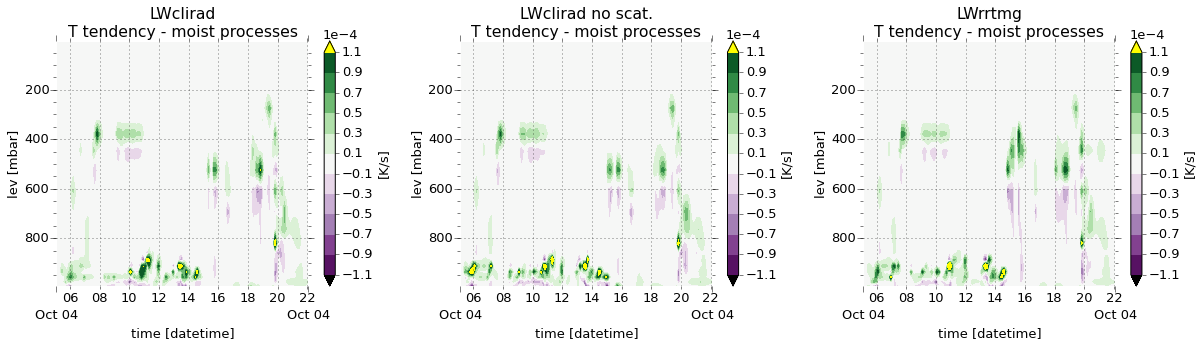

In [150]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'DTCOND', cmap = matplotlib.cm.PRGn)

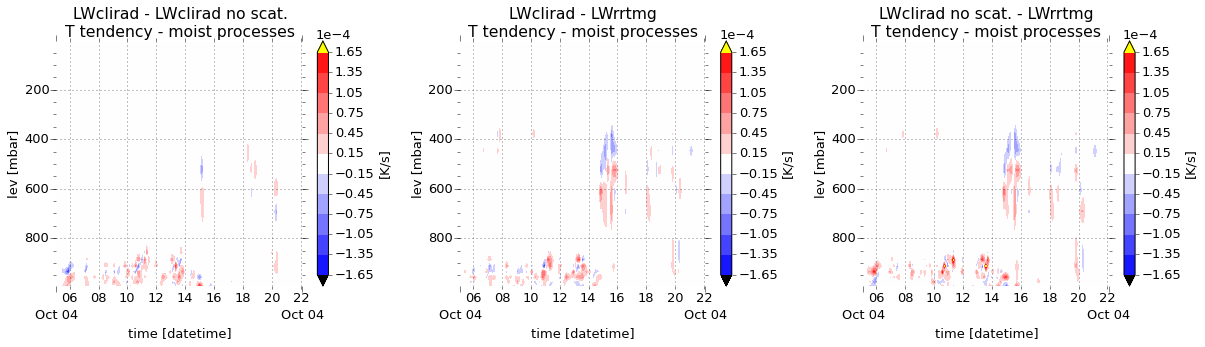

In [151]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'DTCOND', cmap = matplotlib.cm.bwr)

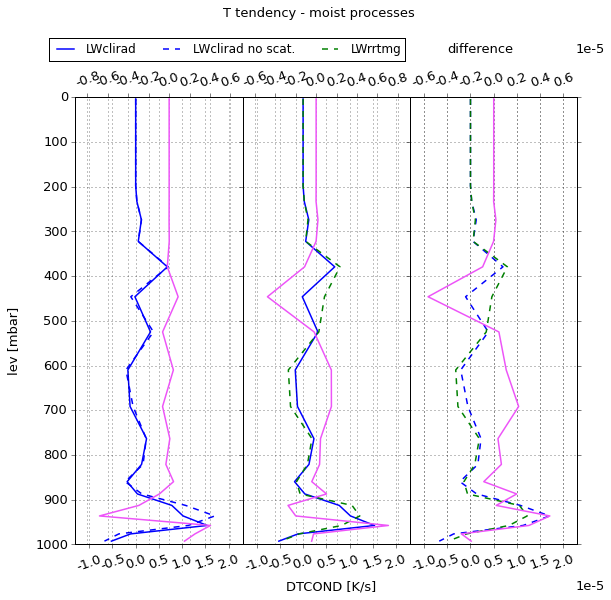

In [152]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'DTCOND', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Prognostic in-cloud ice mixing ratio (ICIMR)

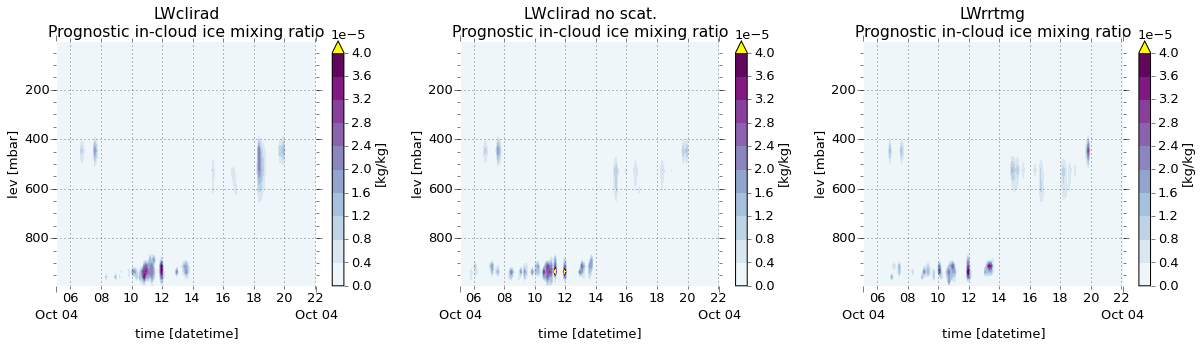

In [153]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'ICIMR', cmap = matplotlib.cm.BuPu)

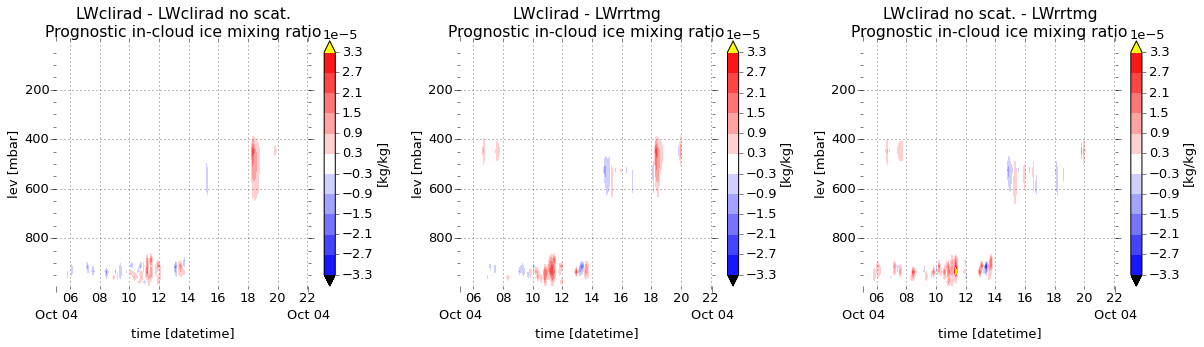

In [154]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'ICIMR', cmap = matplotlib.cm.bwr)

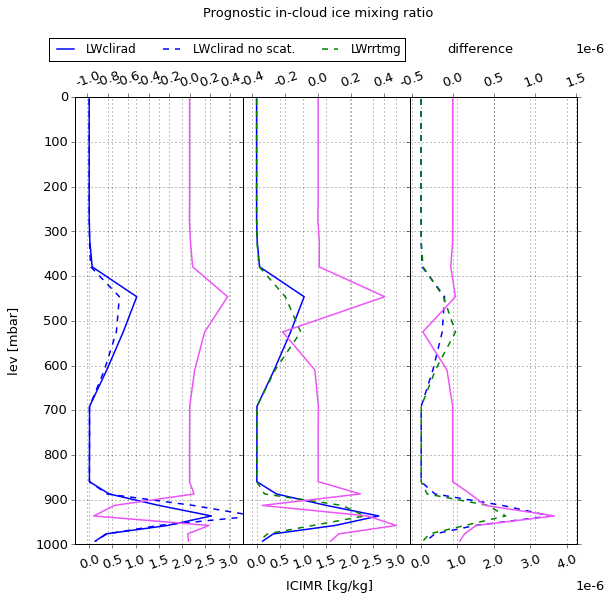

In [155]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'ICIMR', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Prognostic in-cloud water mixing ratio (ICWMR)

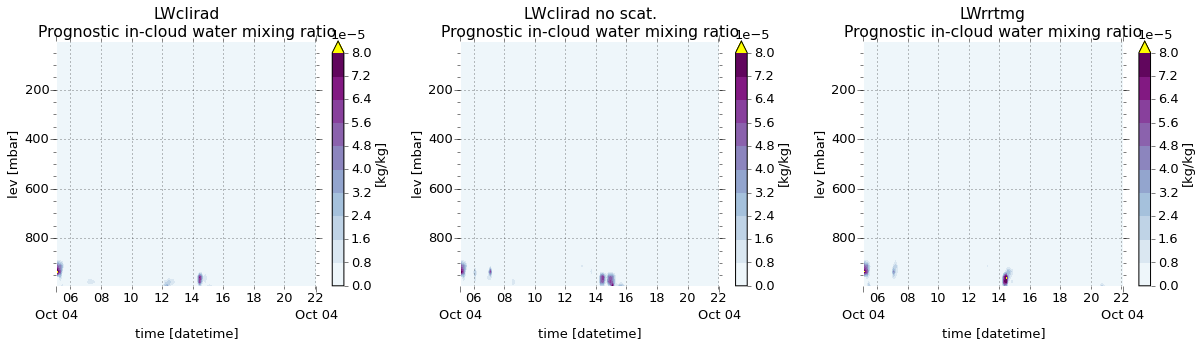

In [156]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'ICWMR', cmap = matplotlib.cm.BuPu)

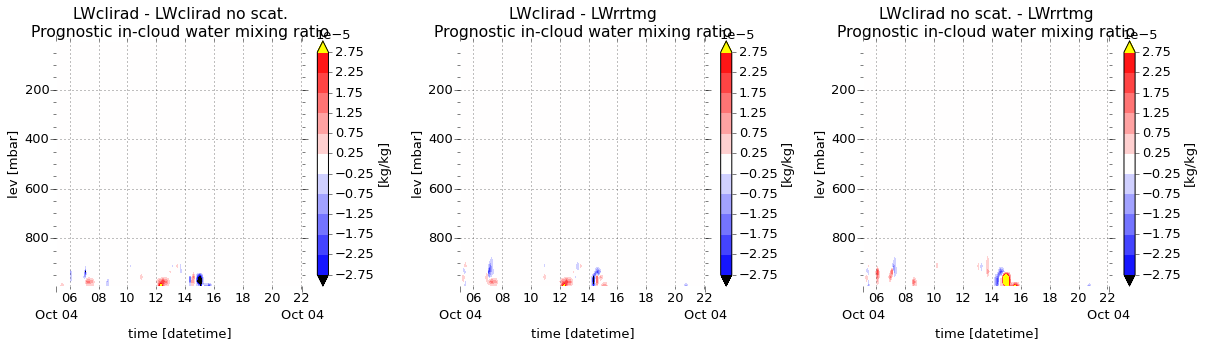

In [157]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'ICWMR', cmap = matplotlib.cm.bwr)

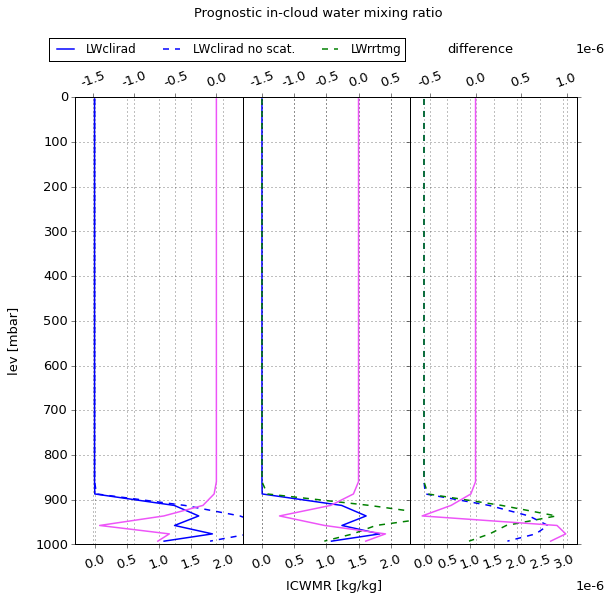

In [158]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'ICWMR', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Grid box averaged cloud ice number (NUMICE)

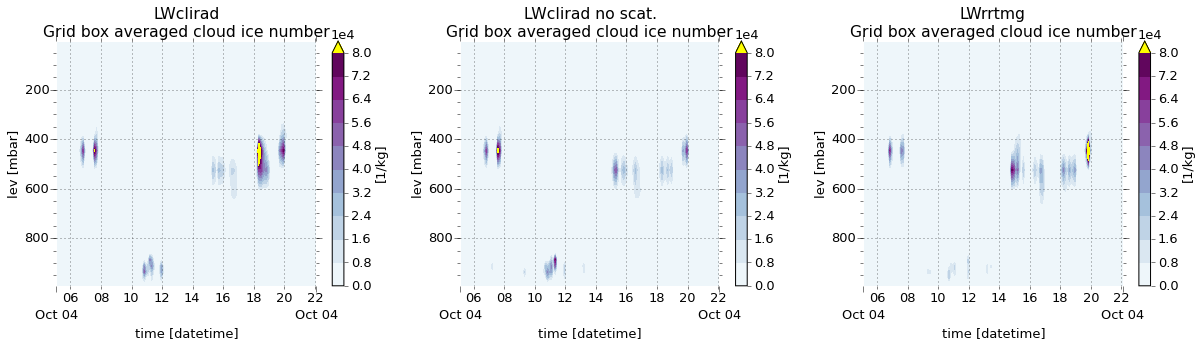

In [159]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'NUMICE', cmap = matplotlib.cm.BuPu)

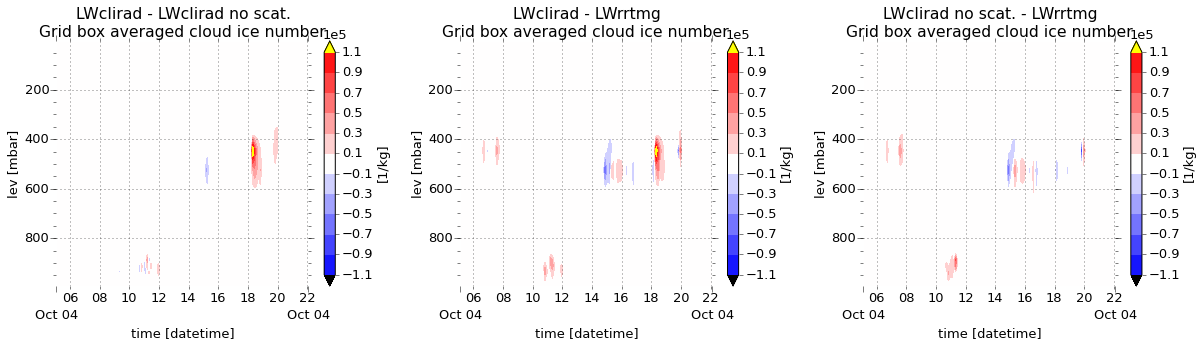

In [160]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'NUMICE', cmap = matplotlib.cm.bwr)

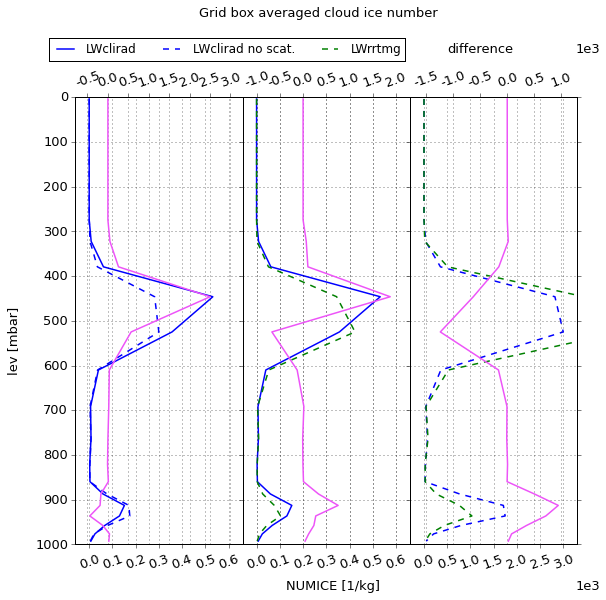

In [161]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'NUMICE', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Grid box averaged cloud liquid number (NUMLIQ)

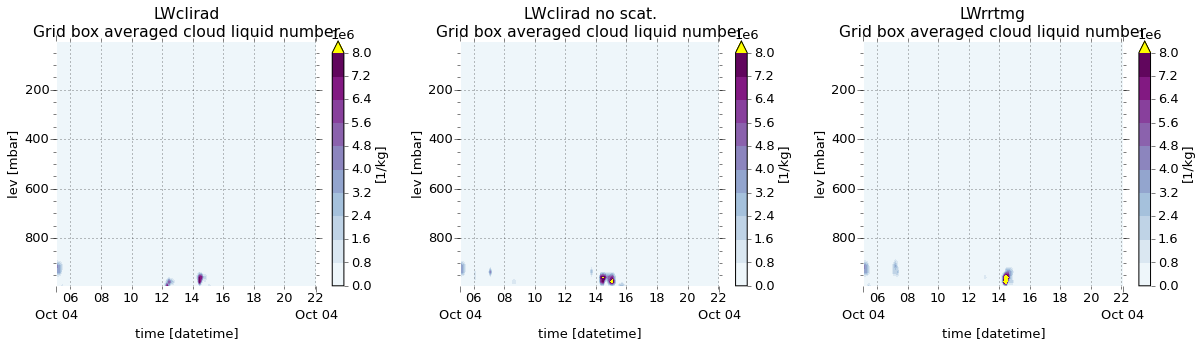

In [162]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'NUMLIQ', cmap = matplotlib.cm.BuPu)

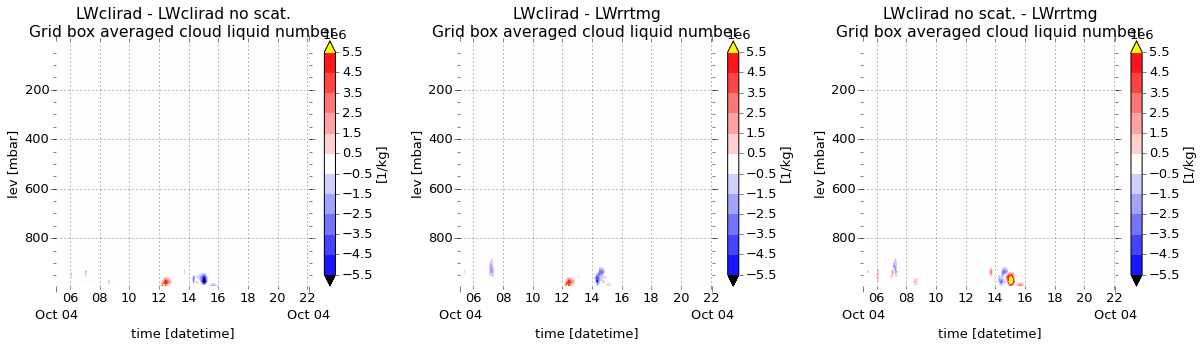

In [163]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'NUMLIQ', cmap = matplotlib.cm.bwr)

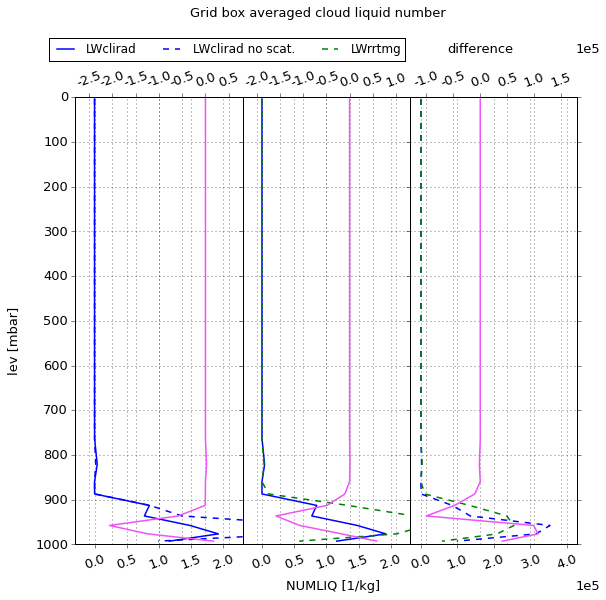

In [164]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'NUMLIQ', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Specific humidity (Q)

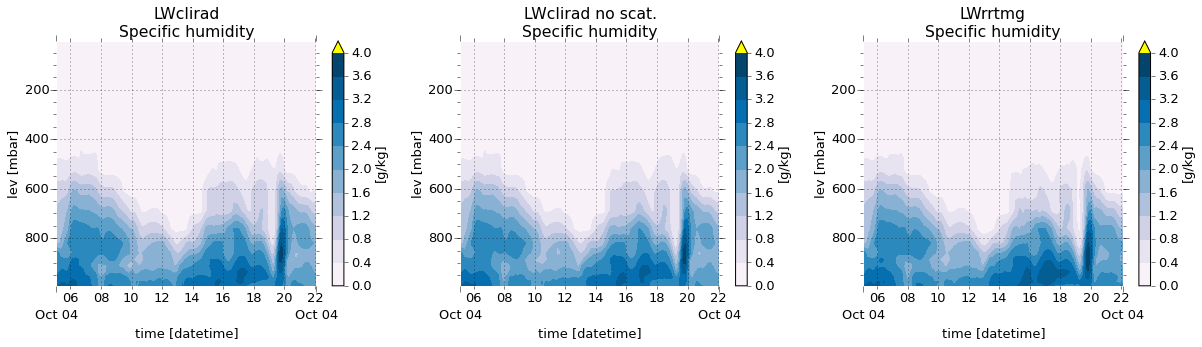

In [165]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'Q', cmap = plt.get_cmap('PuBu'))

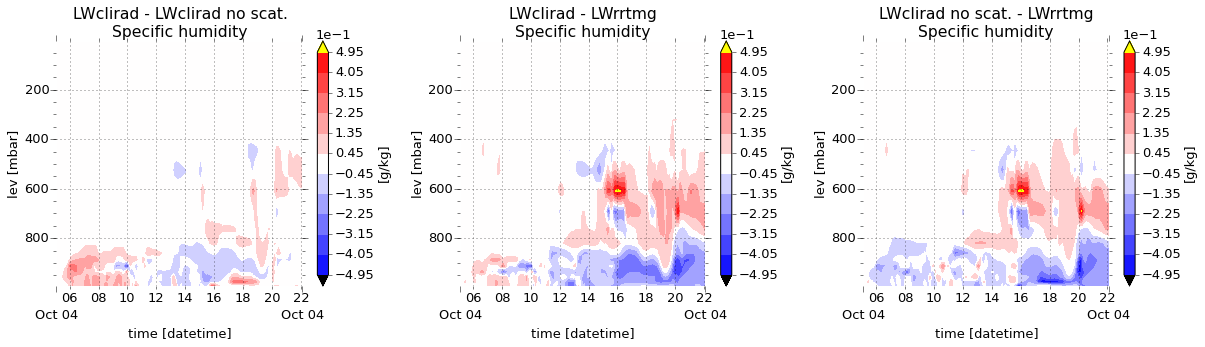

In [166]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'Q', cmap = matplotlib.cm.bwr)

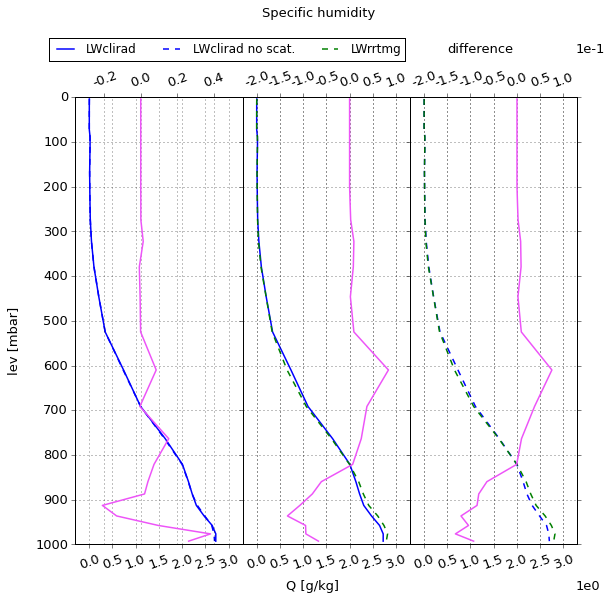

In [167]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'Q', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Longwave heating rate (QRL)

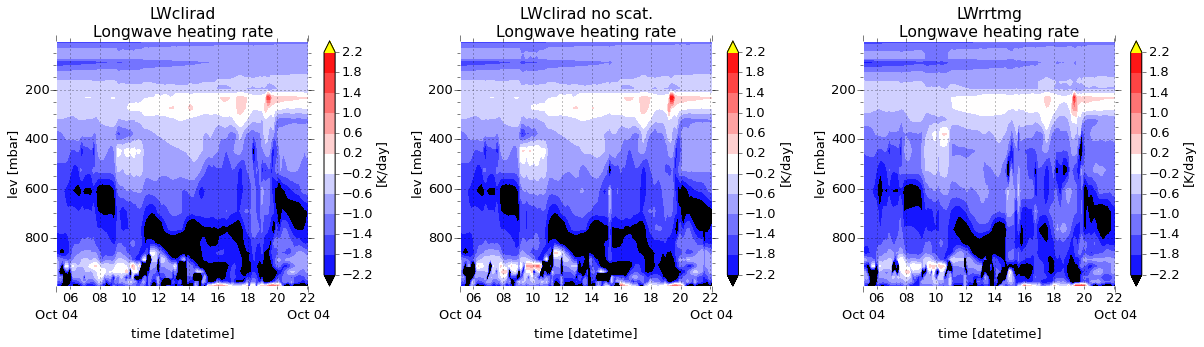

In [168]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'QRL', cmap = matplotlib.cm.bwr,)

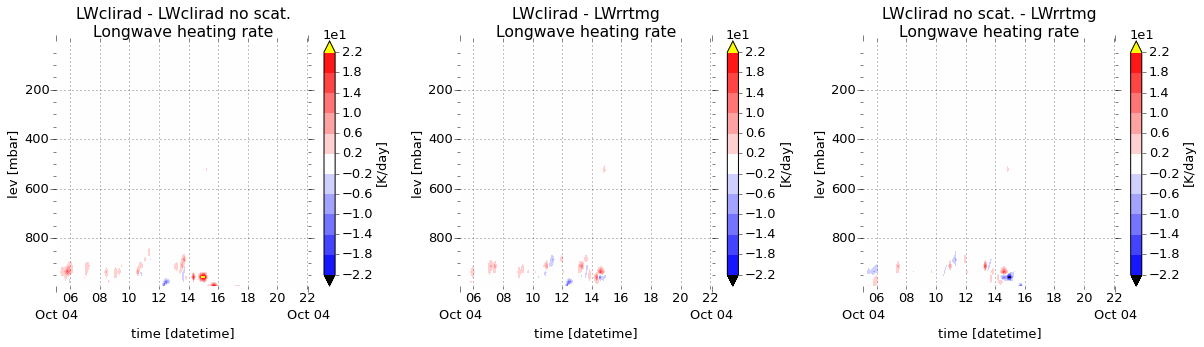

In [169]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'QRL', cmap = plt.get_cmap('bwr'))

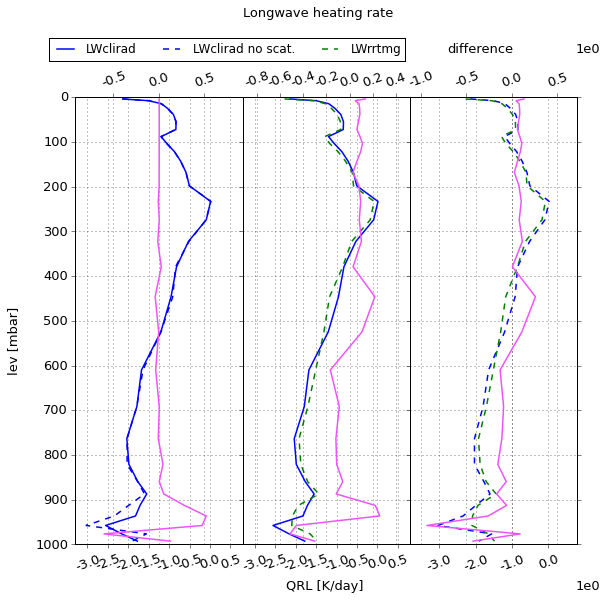

In [170]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'QRL', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### (QRS)

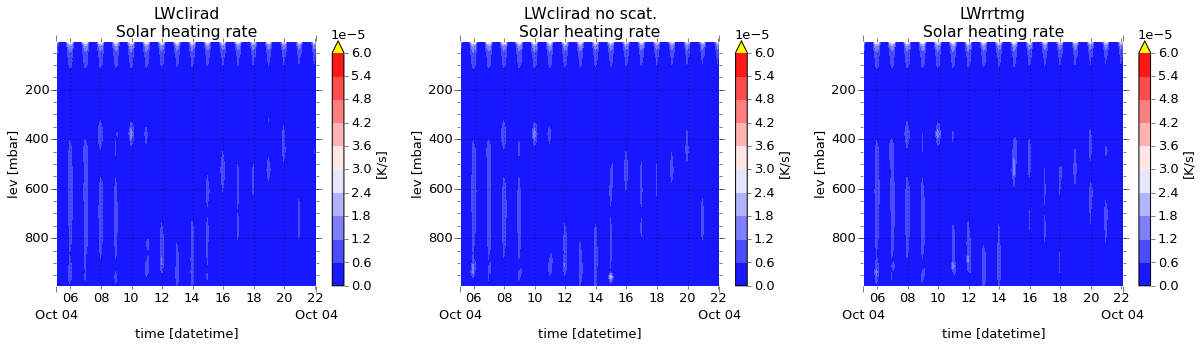

In [171]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'QRS', cmap = matplotlib.cm.bwr,)

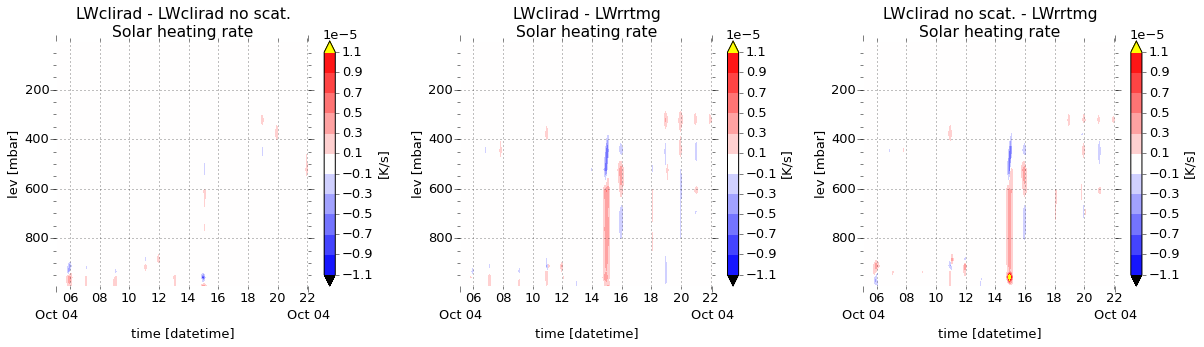

In [172]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'QRS', cmap = plt.get_cmap('bwr'))

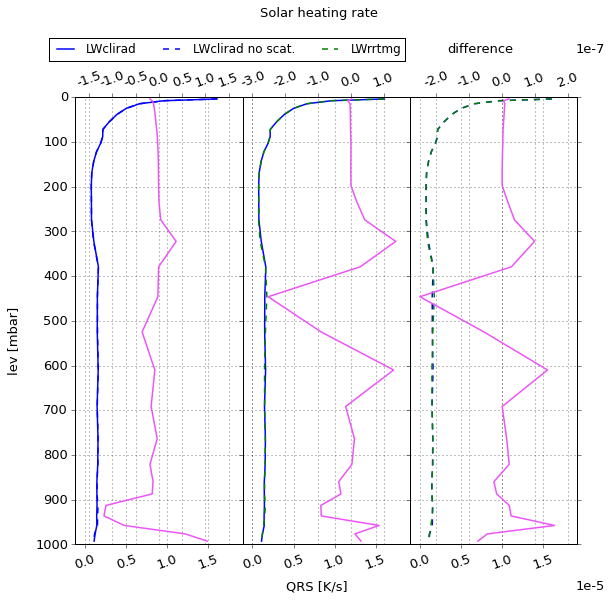

In [173]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'QRS', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

### Temperature (T)

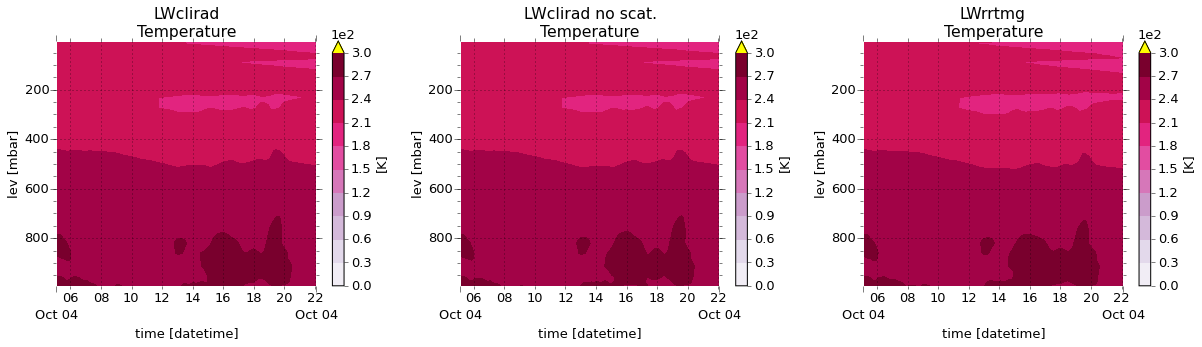

In [174]:
climaviz.contourf_interest_for_all_cases(d3sets, interest = 'T', cmap = matplotlib.cm.PuRd,)

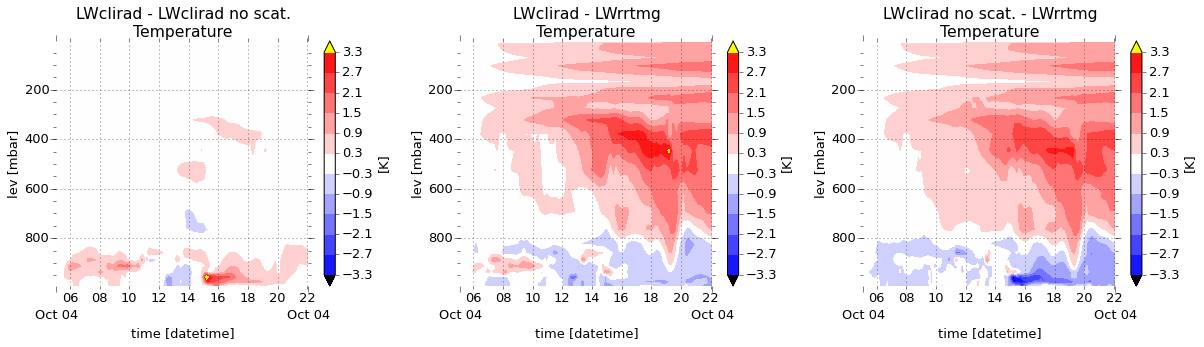

In [175]:
climaviz.contourf_interest_for_all_cases(diff_d3sets, interest = 'T', cmap = plt.get_cmap('bwr'))

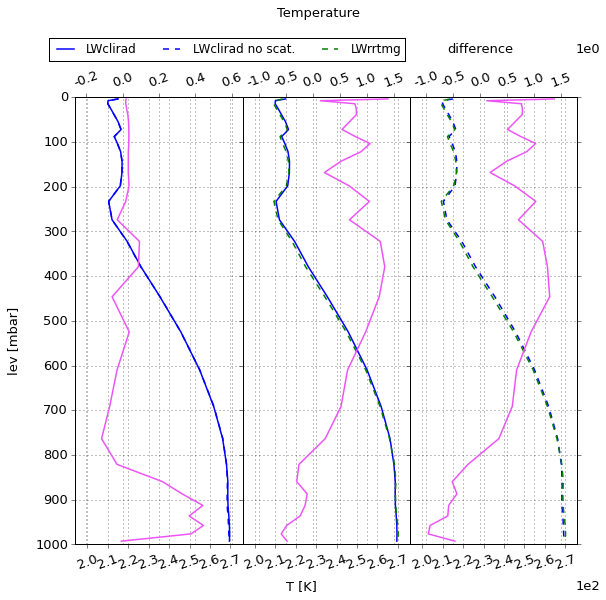

In [176]:
plotVS_timeaveraged_interest_for_all_cases(d3sets, diff_d3sets, interest = 'T', xscale = 'linear',
                                           bot_xlabels_rotate = 20., top_xlabels_rotate = 20.)

# Variables of dimensions (lon, lat, time)

### Net longwave flux at top of model (FLNT)

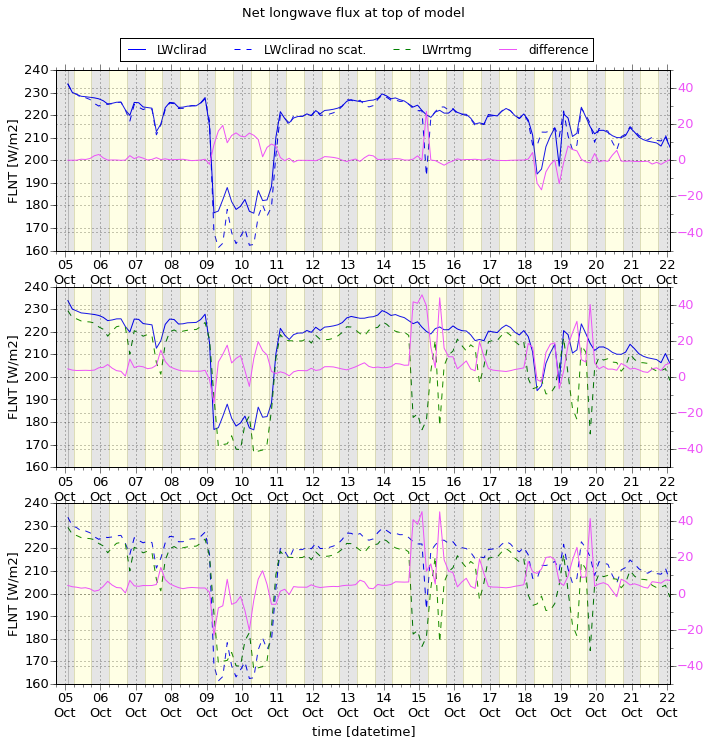

In [177]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'FLNT',
                             left_ylim = (160, 240), right_ylim = (-50, 50))

### Net longwave flux at surface (FLNS)

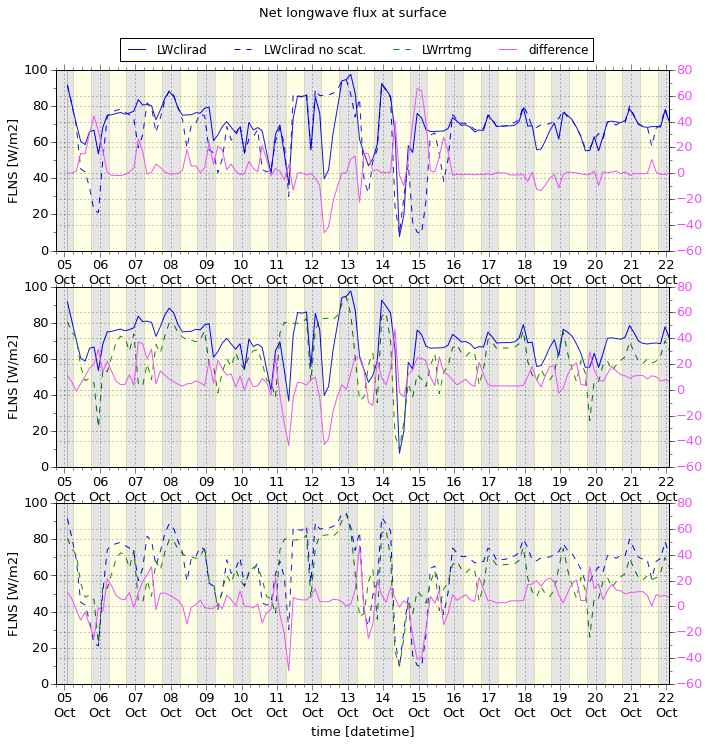

In [178]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'FLNS',
                             left_ylim = (0, 100), right_ylim = (-60, 80))

###  Vertically-integrated low cloud (CLDLOW)

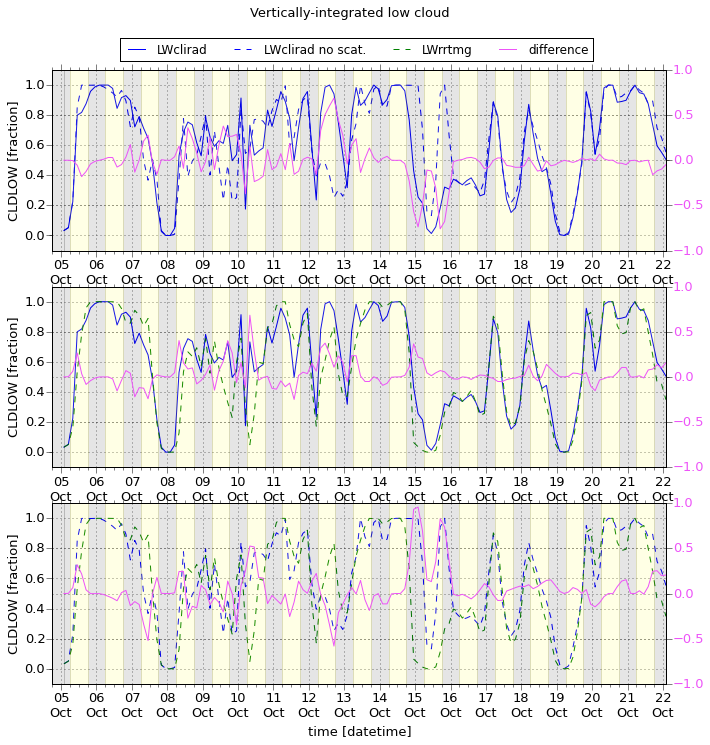

In [179]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDLOW',
                             left_ylim = (-.1, 1.1))

### Vertically-integrated mid-level cloud (CLDMED)

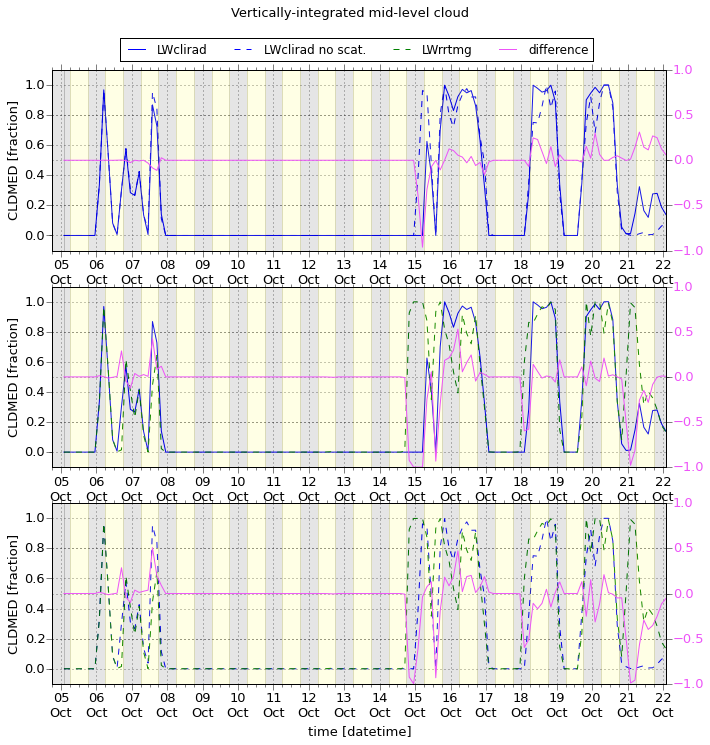

In [180]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDMED',
                             left_ylim = (- .1, 1.1))

###  Vertically-integrated high cloud (CLDHGH)

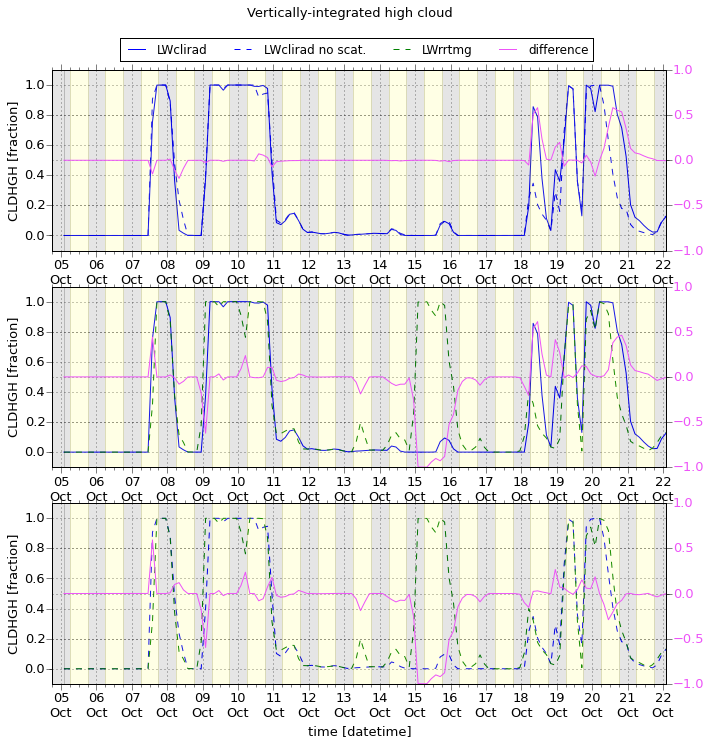

In [181]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDHGH',
                             left_ylim = (- .1, 1.1))

### Vertically-integrated total cloud (CLDTOT)

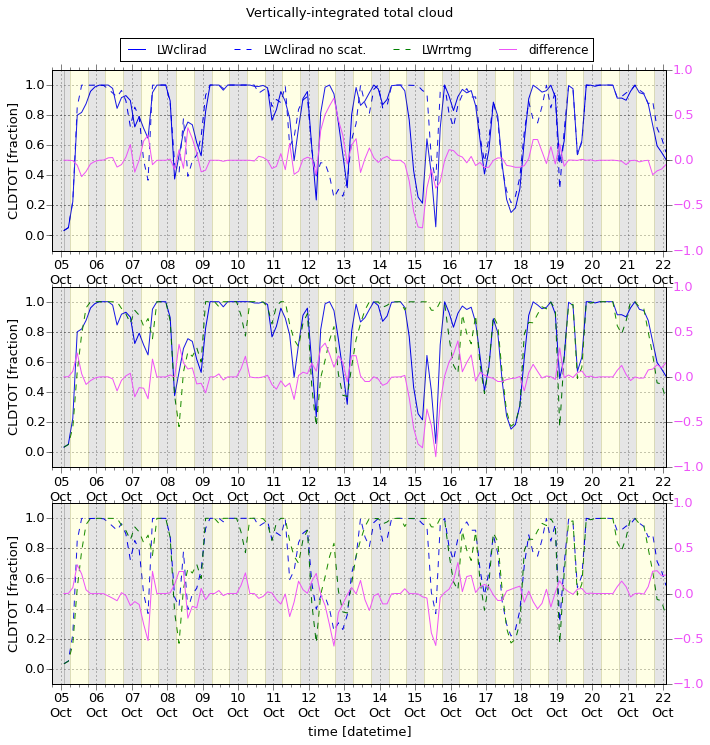

In [182]:
plotVS_interest_for_all_cases(d2sets, diff_d2sets, interest = 'CLDTOT',
                             left_ylim = (- .1, 1.1))